In [1]:
# Libraries and utilities

# RENINDER: FARE FIT.TRANSFORM SOLO SU TRAINING E DOPO SUL TEST SOLO .TRANSFORM
# REMINDER: NORMALIZZARE PRIMA DI FARE TUTTO IL PREPROCESSING 

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import RobustScaler,MinMaxScaler,StandardScaler
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from sklearn.model_selection import StratifiedKFold,RepeatedStratifiedKFold, RandomizedSearchCV,GridSearchCV, RepeatedKFold

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
)

In [2]:
df_train=pd.read_csv("../Dataset_prepared/Prepared_train.csv")
df_test=pd.read_csv("../Dataset_prepared/Prepared_test.csv")

In [3]:
df_train.head()

,vocal_channel,emotion,emotional_intensity,statement,repetition,actor,sex,filename,mean,q25,...,sc_skew_w4,stft_sum_w4,stft_q01_w4,stft_q05_w4,stft_q25_w4,stft_q50_w4,stft_q75_w4,stft_q95_w4,stft_kur_w4,stft_skew_w4
0,speech,neutral,normal,Kids are talking by the door,1st,1,M,03-01-01-01-01-01-01.wav,9.150000e-07,-0.000031,...,-4.175609,740.409892,0.000000,0.566462,0.709962,0.799141,0.896606,1.0,6.742190,-1.706215
1,speech,neutral,normal,Kids are talking by the door,2nd,1,M,03-01-01-01-01-02-01.wav,7.137790e-07,-0.000031,...,-1.100390,705.975006,0.368623,0.472736,0.623183,0.744908,0.874713,1.0,-0.700420,-0.201495
2,speech,neutral,normal,Dogs are sitting by the door,1st,1,M,03-01-01-01-02-01-01.wav,9.554485e-07,0.000000,...,-3.120218,694.365924,0.000000,0.417919,0.643636,0.774253,0.899156,1.0,1.688986,-1.024773
3,speech,neutral,normal,Dogs are sitting by the door,2nd,1,M,03-01-01-01-02-02-01.wav,9.176213e-07,-0.000031,...,-0.880988,663.205667,0.306280,0.399641,0.606910,0.755213,0.886474,1.0,-0.594111,-0.412871
4,speech,calm,normal,Kids are talking by the door,1st,1,M,03-01-02-01-01-01-01.wav,8.108948e-07,-0.000031,...,-1.071109,741.412796,0.248765,0.428202,0.634815,0.759914,0.878014,1.0,0.126535,-0.620782


In [4]:
df_train.drop('actor',axis=1,inplace=True)
df_train.drop('filename',axis=1,inplace=True)

df_test.drop('actor',axis=1,inplace=True)
df_test.drop('filename',axis=1,inplace=True)

In [5]:
le=preprocessing.LabelEncoder()
c = df_train.select_dtypes(include=['object']).columns.tolist()
for i in c:
    df_train[i]=le.fit_transform(df_train[i])

for i in c:
    df_test[i]=le.fit_transform(df_test[i])

Normalizzazione train e test

In [6]:
scaler = StandardScaler()
numeric_features = [n for n in df_train.columns if n!="emotion" and n!= "vocal_channel" and n!= "emotional_intensity" and n!= "statement" and n!= "repetition" and n!= "sex" and n!="filename" and n!="actor"]
scaled_features = scaler.fit_transform(df_train[numeric_features])
df_train[numeric_features] = scaled_features


scaled_features_test = scaler.transform(df_test[numeric_features])
df_test[numeric_features] = scaled_features_test



In [7]:
col=[x for x in df_train.columns if x!="emotion"]
X_train=df_train[col].values
y_train = np.array(df_train["emotion"])

In [8]:
X_test=df_test[col].values
y_test = np.array(df_test["emotion"])

DT

In [29]:
param_grid = {'max_depth': [None, 2, 5, 10, 15, 20],
              'min_samples_split': [2, 5, 10, 15, 20],
              'min_samples_leaf': [1, 5, 10, 15, 20]
}

grid = GridSearchCV(
    DecisionTreeClassifier(),
    param_grid=param_grid,
    cv=StratifiedKFold(), # with no parameters it is with 5 split and 10 repetitions
    refit=True,
    scoring="f1_macro"
)
grid.fit(X_train, y_train)
clf = grid.best_estimator_

In [30]:
print(grid.best_params_)

{'max_depth': 10, 'min_samples_leaf': 20, 'min_samples_split': 2}


In [31]:
learner = DecisionTreeClassifier(max_depth=10,min_samples_split=2,min_samples_leaf=20)
classifier = learner.fit(X_train, y_train)
predictions = classifier.predict(X_test)

print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.46      0.61      0.53        96
           1       0.47      0.33      0.39        96
           2       0.31      0.29      0.30        48
           3       0.26      0.21      0.23        96
           4       0.24      0.22      0.23        96
           5       0.29      0.48      0.36        48
           6       0.31      0.29      0.30        96
           7       0.44      0.44      0.44        48

    accuracy                           0.35       624
   macro avg       0.35      0.36      0.35       624
weighted avg       0.35      0.35      0.34       624



KNN

In [32]:
X_train=df_train[col].values
y_train = np.array(df_train["emotion"])

In [33]:
param_grid = {
    "n_neighbors": np.arange(2,51),
    "weights": ["uniform", "distance"],
    "metric": ["euclidean", "cityblock","minkowski"], # cityblock is the manhattan distance
}

grid = GridSearchCV(
    KNeighborsClassifier(),
    param_grid=param_grid,
    cv=StratifiedKFold(), # with no parameters it is with 5 split and 10 repetitions
    refit=True,
    scoring="f1_macro"
)

grid.fit(X_train, y_train)
clf = grid.best_estimator_

In [34]:
print(grid.best_params_)

{'metric': 'cityblock', 'n_neighbors': 40, 'weights': 'distance'}


In [60]:
X_test=df_test[col].values
y_test = np.array(df_test["emotion"])

In [35]:
learner = KNeighborsClassifier(n_neighbors= 40, metric= 'cityblock', weights= 'distance')
classifier = learner.fit(X_train, y_train)
predictions = classifier.predict(X_test)

print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.55      0.59      0.57        96
           1       0.49      0.56      0.52        96
           2       0.50      0.27      0.35        48
           3       0.45      0.39      0.41        96
           4       0.34      0.45      0.39        96
           5       0.42      0.27      0.33        48
           6       0.27      0.24      0.26        96
           7       0.28      0.35      0.31        48

    accuracy                           0.41       624
   macro avg       0.41      0.39      0.39       624
weighted avg       0.42      0.41      0.41       624



PCA

In [59]:
from sklearn.decomposition import PCA
colors = np.array(["black", "green","red","orange","yellow","green","blue","grey"])

X_train.shape

(1828, 258)

In [60]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train)
X_pca.shape

(1828, 2)

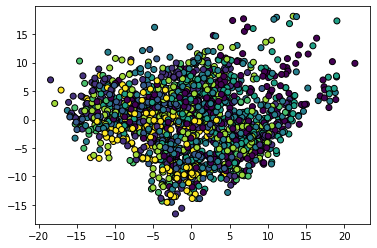

In [76]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train,edgecolors='k')
plt.show()


# Undersampling 

In [103]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import CondensedNearestNeighbour
from imblearn.under_sampling import TomekLinks
from imblearn.under_sampling import EditedNearestNeighbours
from collections import Counter

Random Undersampler

In [104]:
rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({0: 140, 1: 140, 2: 140, 3: 140, 4: 140, 5: 140, 6: 140, 7: 140})


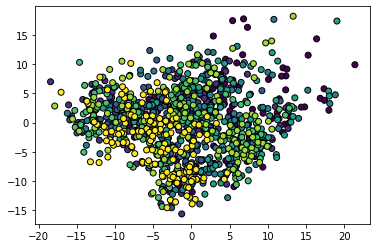

In [105]:
pca = PCA(n_components=2)
pca.fit(X_train) # original training set
X_pca = pca.transform(X_res) # then transform the undersampled
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_res,edgecolor='k')
plt.show()

In [109]:
learner= DecisionTreeClassifier(max_depth=10, min_samples_split=2, min_samples_leaf=20)
learner.fit(X_res, y_res)
y_pred = learner.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.56      0.57      0.57        96
           1       0.56      0.57      0.56        96
           2       0.18      0.29      0.22        48
           3       0.30      0.20      0.24        96
           4       0.38      0.32      0.35        96
           5       0.39      0.44      0.41        48
           6       0.49      0.23      0.31        96
           7       0.32      0.71      0.44        48

    accuracy                           0.40       624
   macro avg       0.40      0.42      0.39       624
weighted avg       0.42      0.40      0.40       624



In [112]:
learner = KNeighborsClassifier(n_neighbors= 40, metric= 'cityblock', weights= 'distance')
learner.fit(X_res, y_res)
y_pred = learner.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.68      0.51      0.58        96
           1       0.58      0.35      0.44        96
           2       0.38      0.52      0.44        48
           3       0.56      0.20      0.29        96
           4       0.36      0.33      0.35        96
           5       0.24      0.71      0.36        48
           6       0.44      0.08      0.14        96
           7       0.23      0.69      0.34        48

    accuracy                           0.38       624
   macro avg       0.43      0.42      0.37       624
weighted avg       0.47      0.38      0.36       624



Condensed Nearest Neighbour 

In [113]:
cnn = CondensedNearestNeighbour(random_state=42)
X_res, y_res = cnn.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({5: 140, 6: 121, 1: 119, 4: 110, 3: 92, 0: 73, 2: 61, 7: 60})


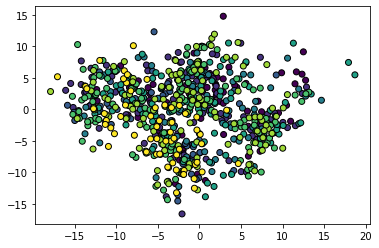

In [114]:
pca = PCA(n_components=2)
pca.fit(X_train) # original training set
X_pca = pca.transform(X_res) # then transform the undersampled
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_res,edgecolor='k')
plt.show()

In [116]:
learner= DecisionTreeClassifier(max_depth=10, min_samples_split=2, min_samples_leaf=20)
learner.fit(X_res, y_res)
y_pred = learner.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.36      0.59      0.45        96
           1       0.49      0.36      0.42        96
           2       0.49      0.38      0.42        48
           3       0.25      0.20      0.22        96
           4       0.22      0.22      0.22        96
           5       0.24      0.69      0.35        48
           6       0.21      0.08      0.12        96
           7       0.38      0.06      0.11        48

    accuracy                           0.31       624
   macro avg       0.33      0.32      0.29       624
weighted avg       0.32      0.31      0.29       624



In [118]:
learner = KNeighborsClassifier(n_neighbors= 40, metric= 'cityblock', weights= 'distance')
learner.fit(X_res, y_res)
y_pred = learner.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.72      0.44      0.55        96
           1       0.41      0.20      0.27        96
           2       0.47      0.19      0.27        48
           3       0.50      0.23      0.31        96
           4       0.27      0.33      0.30        96
           5       0.19      0.92      0.31        48
           6       0.31      0.16      0.21        96
           7       0.37      0.42      0.39        48

    accuracy                           0.33       624
   macro avg       0.41      0.36      0.33       624
weighted avg       0.42      0.33      0.33       624



Tomek Links

In [119]:
tl = TomekLinks()
X_res, y_res = tl.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({0: 261, 3: 255, 1: 251, 6: 250, 4: 249, 5: 140, 2: 128, 7: 128})


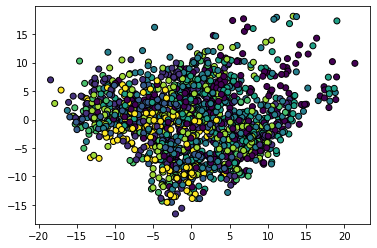

In [120]:
pca = PCA(n_components=2)
pca.fit(X_train) # original training set
X_pca = pca.transform(X_res) # then transform the undersampled
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_res,edgecolor='k')
plt.show()

In [122]:
learner= DecisionTreeClassifier(max_depth=10, min_samples_split=2, min_samples_leaf=20)
learner.fit(X_res, y_res)
y_pred = learner.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.45      0.61      0.52        96
           1       0.31      0.35      0.33        96
           2       0.27      0.31      0.29        48
           3       0.29      0.22      0.25        96
           4       0.26      0.16      0.20        96
           5       0.33      0.33      0.33        48
           6       0.36      0.34      0.35        96
           7       0.32      0.38      0.34        48

    accuracy                           0.34       624
   macro avg       0.32      0.34      0.33       624
weighted avg       0.33      0.34      0.33       624



In [125]:
learner = KNeighborsClassifier(n_neighbors= 40, metric= 'cityblock', weights= 'distance')
learner.fit(X_res, y_res)
y_pred = learner.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.52      0.60      0.56        96
           1       0.41      0.53      0.46        96
           2       0.48      0.27      0.35        48
           3       0.48      0.34      0.40        96
           4       0.35      0.39      0.36        96
           5       0.39      0.38      0.38        48
           6       0.32      0.25      0.28        96
           7       0.34      0.46      0.39        48

    accuracy                           0.41       624
   macro avg       0.41      0.40      0.40       624
weighted avg       0.41      0.41      0.40       624



Edited Nearest Neighbours

In [126]:
enn = EditedNearestNeighbours()
X_res, y_res = enn.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({5: 140, 1: 65, 0: 53, 3: 40, 4: 30, 6: 30, 7: 17, 2: 13})


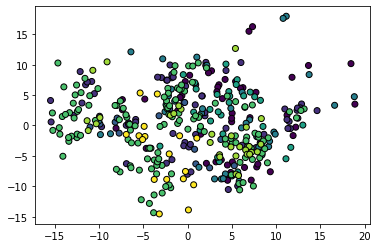

In [127]:
pca = PCA(n_components=2)
pca.fit(X_train) # original training set
X_pca = pca.transform(X_res) # then transform the undersampled
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_res,edgecolor='k')
plt.show()

In [128]:
learner= DecisionTreeClassifier(max_depth=10, min_samples_split=2, min_samples_leaf=20)
learner.fit(X_res, y_res)
y_pred = learner.predict(X_test)
print(classification_report(y_test, y_pred,zero_division=0))

              precision    recall  f1-score   support

           0       0.73      0.17      0.27        96
           1       0.38      0.52      0.44        96
           2       0.00      0.00      0.00        48
           3       0.26      0.11      0.16        96
           4       0.41      0.30      0.35        96
           5       0.16      0.94      0.27        48
           6       0.27      0.20      0.23        96
           7       0.00      0.00      0.00        48

    accuracy                           0.27       624
   macro avg       0.28      0.28      0.21       624
weighted avg       0.33      0.27      0.24       624



In [131]:
learner = KNeighborsClassifier(n_neighbors= 40, metric= 'cityblock', weights= 'distance')
learner.fit(X_res, y_res)
y_pred = learner.predict(X_test)
print(classification_report(y_test,y_pred,zero_division=0))

              precision    recall  f1-score   support

           0       0.64      0.33      0.44        96
           1       0.50      0.03      0.06        96
           2       0.00      0.00      0.00        48
           3       0.63      0.18      0.28        96
           4       0.06      0.01      0.02        96
           5       0.09      1.00      0.17        48
           6       0.00      0.00      0.00        96
           7       0.00      0.00      0.00        48

    accuracy                           0.16       624
   macro avg       0.24      0.19      0.12       624
weighted avg       0.29      0.16      0.13       624



Cluster Centroids

In [134]:
from sklearn.cluster import MiniBatchKMeans
from imblearn.under_sampling import ClusterCentroids
import warnings
warnings.simplefilter("ignore")

In [135]:
cc = ClusterCentroids(
    estimator=MiniBatchKMeans(n_init=1, random_state=0), random_state=42, # minibatch version is faster than Kmeans
)
X_res, y_res = cc.fit_resample(X_train, y_train,)
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({0: 140, 1: 140, 2: 140, 3: 140, 4: 140, 5: 140, 6: 140, 7: 140})


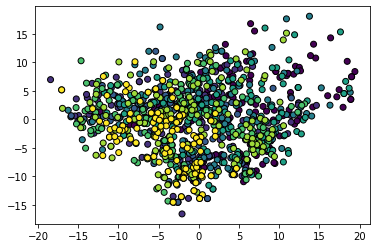

In [136]:
pca = PCA(n_components=2)
pca.fit(X_train) # original training set
X_pca = pca.transform(X_res) # then transform the undersampled
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_res,edgecolor='k')
plt.show()

In [139]:
learner= DecisionTreeClassifier(max_depth=10, min_samples_split=2, min_samples_leaf=20)
learner.fit(X_res, y_res)
y_pred = learner.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.45      0.61      0.52        96
           1       0.42      0.39      0.40        96
           2       0.29      0.31      0.30        48
           3       0.32      0.20      0.25        96
           4       0.29      0.23      0.25        96
           5       0.28      0.58      0.38        48
           6       0.16      0.08      0.11        96
           7       0.30      0.44      0.36        48

    accuracy                           0.33       624
   macro avg       0.31      0.36      0.32       624
weighted avg       0.32      0.33      0.32       624



In [142]:
learner = KNeighborsClassifier(n_neighbors= 40, metric= 'cityblock', weights= 'distance')
learner.fit(X_res, y_res)
y_pred = learner.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.63      0.54      0.58        96
           1       0.52      0.31      0.39        96
           2       0.42      0.52      0.46        48
           3       0.51      0.24      0.33        96
           4       0.30      0.25      0.27        96
           5       0.26      0.81      0.39        48
           6       0.30      0.09      0.14        96
           7       0.28      0.69      0.40        48

    accuracy                           0.38       624
   macro avg       0.40      0.43      0.37       624
weighted avg       0.42      0.38      0.36       624



# Oversampling

In [143]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN

Random Oversampler

In [144]:
ros = RandomOverSampler(random_state=42)
X_res, y_res = ros.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({5: 280, 1: 280, 4: 280, 6: 280, 0: 280, 3: 280, 2: 280, 7: 280})


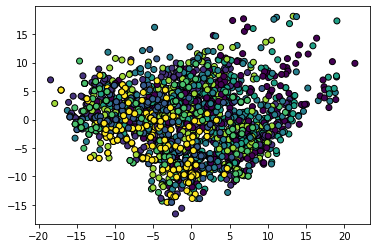

In [145]:
pca = PCA(n_components=2)
pca.fit(X_train) # original training set
X_pca = pca.transform(X_res) # then transform the undersampled
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_res,edgecolor='k')
plt.show()

In [146]:
learner= DecisionTreeClassifier(max_depth=10, min_samples_split=2, min_samples_leaf=20)
learner.fit(X_res, y_res)
y_pred = learner.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.53      0.55      0.54        96
           1       0.47      0.29      0.36        96
           2       0.27      0.33      0.30        48
           3       0.27      0.24      0.25        96
           4       0.38      0.29      0.33        96
           5       0.23      0.38      0.29        48
           6       0.31      0.34      0.33        96
           7       0.40      0.54      0.46        48

    accuracy                           0.36       624
   macro avg       0.36      0.37      0.36       624
weighted avg       0.37      0.36      0.36       624



In [147]:
learner = KNeighborsClassifier(n_neighbors= 40, metric= 'cityblock', weights= 'distance')
learner.fit(X_res, y_res)
y_pred = learner.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.63      0.54      0.58        96
           1       0.48      0.29      0.36        96
           2       0.39      0.54      0.45        48
           3       0.57      0.28      0.38        96
           4       0.41      0.40      0.40        96
           5       0.21      0.67      0.32        48
           6       0.47      0.08      0.14        96
           7       0.26      0.58      0.36        48

    accuracy                           0.38       624
   macro avg       0.43      0.42      0.38       624
weighted avg       0.46      0.38      0.37       624



Smote

In [148]:
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({5: 280, 1: 280, 4: 280, 6: 280, 0: 280, 3: 280, 2: 280, 7: 280})


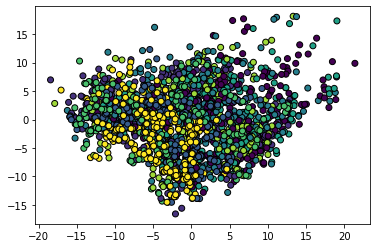

In [149]:
pca = PCA(n_components=2)
pca.fit(X_train) # original training set
X_pca = pca.transform(X_res) # then transform the undersampled
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_res,edgecolor='k')
plt.show()

In [150]:
learner= DecisionTreeClassifier(max_depth=10, min_samples_split=2, min_samples_leaf=20)
learner.fit(X_res, y_res)
y_pred = learner.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.44      0.49      0.46        96
           1       0.41      0.36      0.38        96
           2       0.21      0.35      0.26        48
           3       0.29      0.26      0.28        96
           4       0.26      0.21      0.23        96
           5       0.33      0.56      0.42        48
           6       0.48      0.28      0.36        96
           7       0.30      0.31      0.31        48

    accuracy                           0.34       624
   macro avg       0.34      0.35      0.34       624
weighted avg       0.35      0.34      0.34       624



In [151]:
learner = KNeighborsClassifier(n_neighbors= 40, metric= 'cityblock', weights= 'distance')
learner.fit(X_res, y_res)
y_pred = learner.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.64      0.49      0.55        96
           1       0.61      0.29      0.39        96
           2       0.41      0.62      0.50        48
           3       0.69      0.26      0.38        96
           4       0.38      0.31      0.34        96
           5       0.22      0.79      0.34        48
           6       0.58      0.15      0.23        96
           7       0.27      0.65      0.38        48

    accuracy                           0.39       624
   macro avg       0.47      0.45      0.39       624
weighted avg       0.51      0.39      0.39       624



Adasyn

In [152]:
ada = ADASYN(random_state=42)
X_res, y_res = ada.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({7: 292, 5: 280, 1: 280, 4: 280, 6: 280, 0: 280, 3: 280, 2: 278})


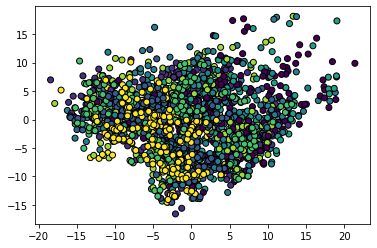

In [153]:
pca = PCA(n_components=2)
pca.fit(X_train) # original training set
X_pca = pca.transform(X_res) # then transform the undersampled
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_res,edgecolor='k')
plt.show()

In [154]:
learner= DecisionTreeClassifier(max_depth=10, min_samples_split=2, min_samples_leaf=20)
learner.fit(X_res, y_res)
y_pred = learner.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.48      0.48      0.48        96
           1       0.42      0.38      0.40        96
           2       0.21      0.35      0.26        48
           3       0.37      0.33      0.35        96
           4       0.22      0.18      0.20        96
           5       0.30      0.31      0.31        48
           6       0.26      0.22      0.24        96
           7       0.30      0.42      0.35        48

    accuracy                           0.33       624
   macro avg       0.32      0.33      0.32       624
weighted avg       0.33      0.33      0.33       624



In [155]:
learner = KNeighborsClassifier(n_neighbors= 40, metric= 'cityblock', weights= 'distance')
learner.fit(X_res, y_res)
y_pred = learner.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.67      0.50      0.57        96
           1       0.60      0.22      0.32        96
           2       0.38      0.60      0.47        48
           3       0.74      0.24      0.36        96
           4       0.39      0.26      0.31        96
           5       0.18      0.73      0.29        48
           6       0.33      0.03      0.06        96
           7       0.26      0.77      0.38        48

    accuracy                           0.35       624
   macro avg       0.44      0.42      0.35       624
weighted avg       0.48      0.35      0.34       624



Class Weight --> skip beacuse too many labels for target emotion

Corrected Decision Tree

In [164]:
from sklearn.tree._tree import TREE_LEAF
from sklearn import tree

def is_leaf(inner_tree, index):
    # Check whether node is leaf node
    return (inner_tree.children_left[index] == TREE_LEAF and
            inner_tree.children_right[index] == TREE_LEAF)


def prune_index(inner_tree, decisions, index=0):
    # Start pruning from the bottom - if we start from the top, we might miss
    # nodes that become leaves during pruning.
    # Do not use this directly - use prune_duplicate_leaves instead.
    if not is_leaf(inner_tree, inner_tree.children_left[index]):
        prune_index(inner_tree, decisions, inner_tree.children_left[index])
    if not is_leaf(inner_tree, inner_tree.children_right[index]):
        prune_index(inner_tree, decisions, inner_tree.children_right[index])

    # Prune children if both children are leaves now and make the same decision:
    if (is_leaf(inner_tree, inner_tree.children_left[index]) and
        is_leaf(inner_tree, inner_tree.children_right[index]) and
        (decisions[index] == decisions[inner_tree.children_left[index]]) and
        (decisions[index] == decisions[inner_tree.children_right[index]])):
        # turn node into a leaf by "unlinking" its children
        inner_tree.children_left[index] = TREE_LEAF
        inner_tree.children_right[index] = TREE_LEAF
        # print("Pruned {}".format(index))


def prune_duplicate_leaves(dt):
    # Remove leaves if both
    decisions = dt.tree_.value.argmax(axis=2).flatten().tolist()  # Decision for each node
    prune_index(dt.tree_, decisions)

In [168]:
learner= DecisionTreeClassifier(max_depth=10, min_samples_split=2, min_samples_leaf=20)
learner.fit(X_res, y_res)

DecisionTreeClassifier(max_depth=10, min_samples_leaf=20)

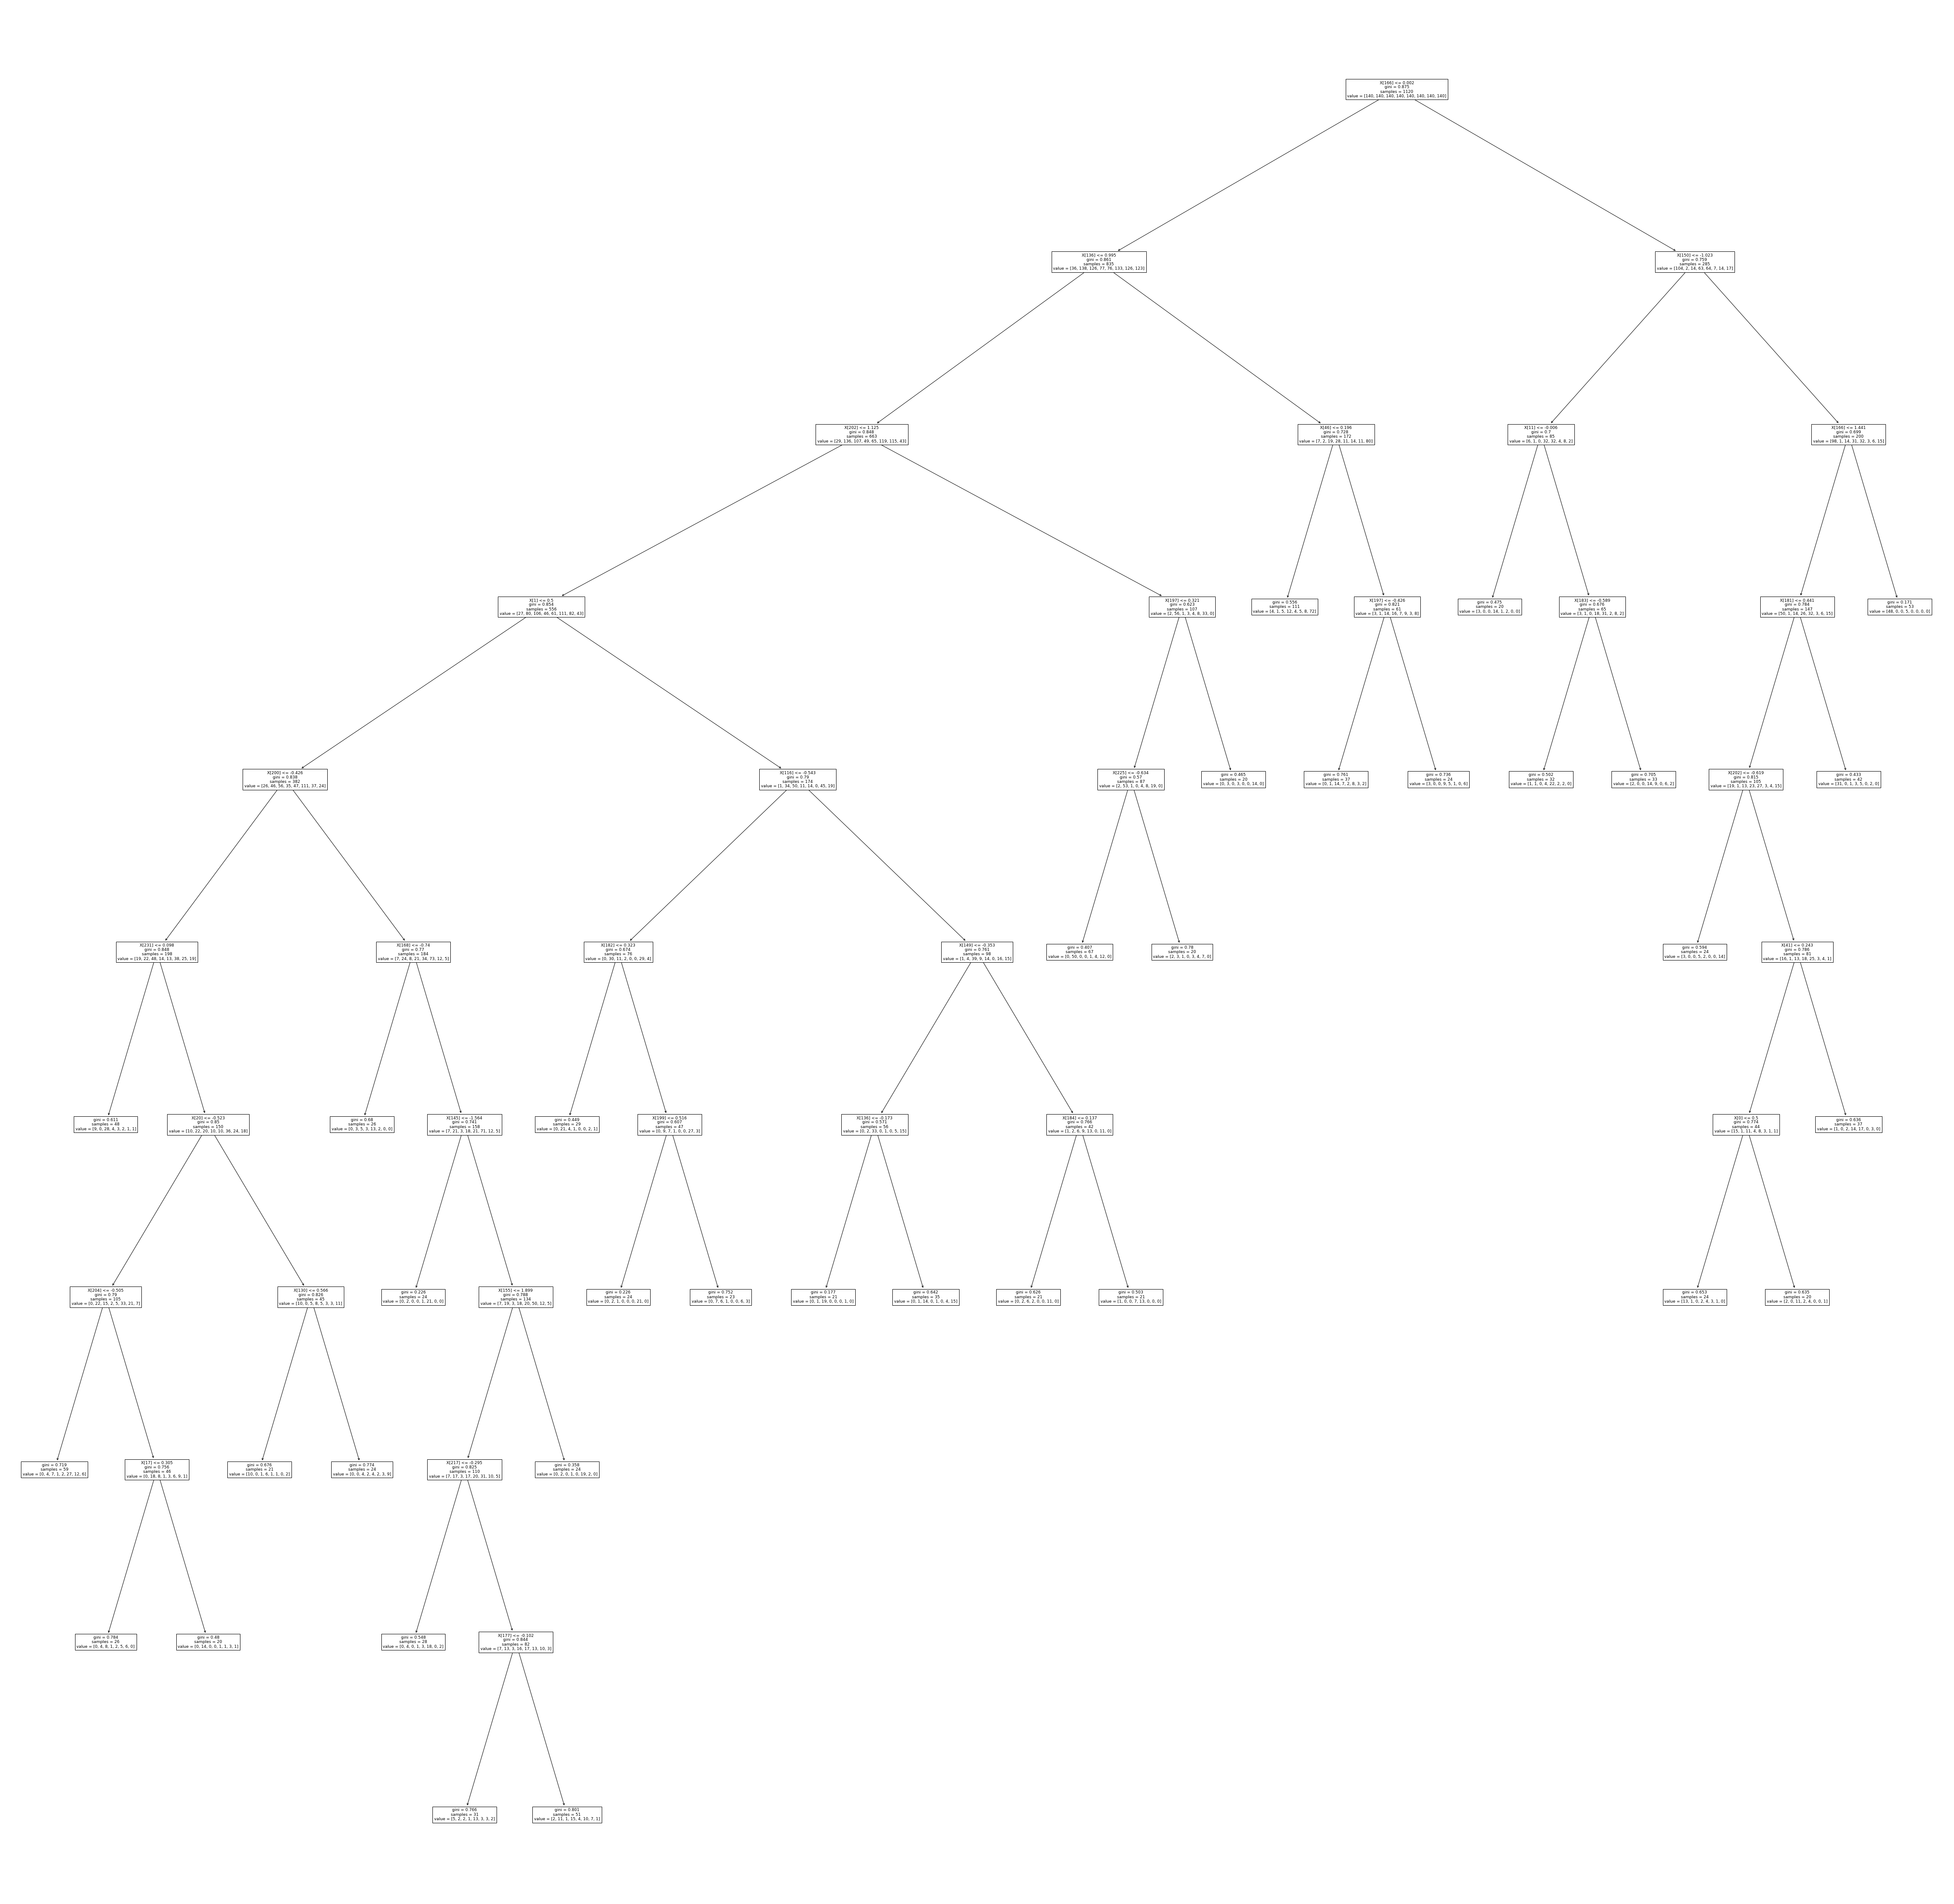

In [169]:
plt.figure(figsize=(80,80))
tree.plot_tree(clf)
plt.show()

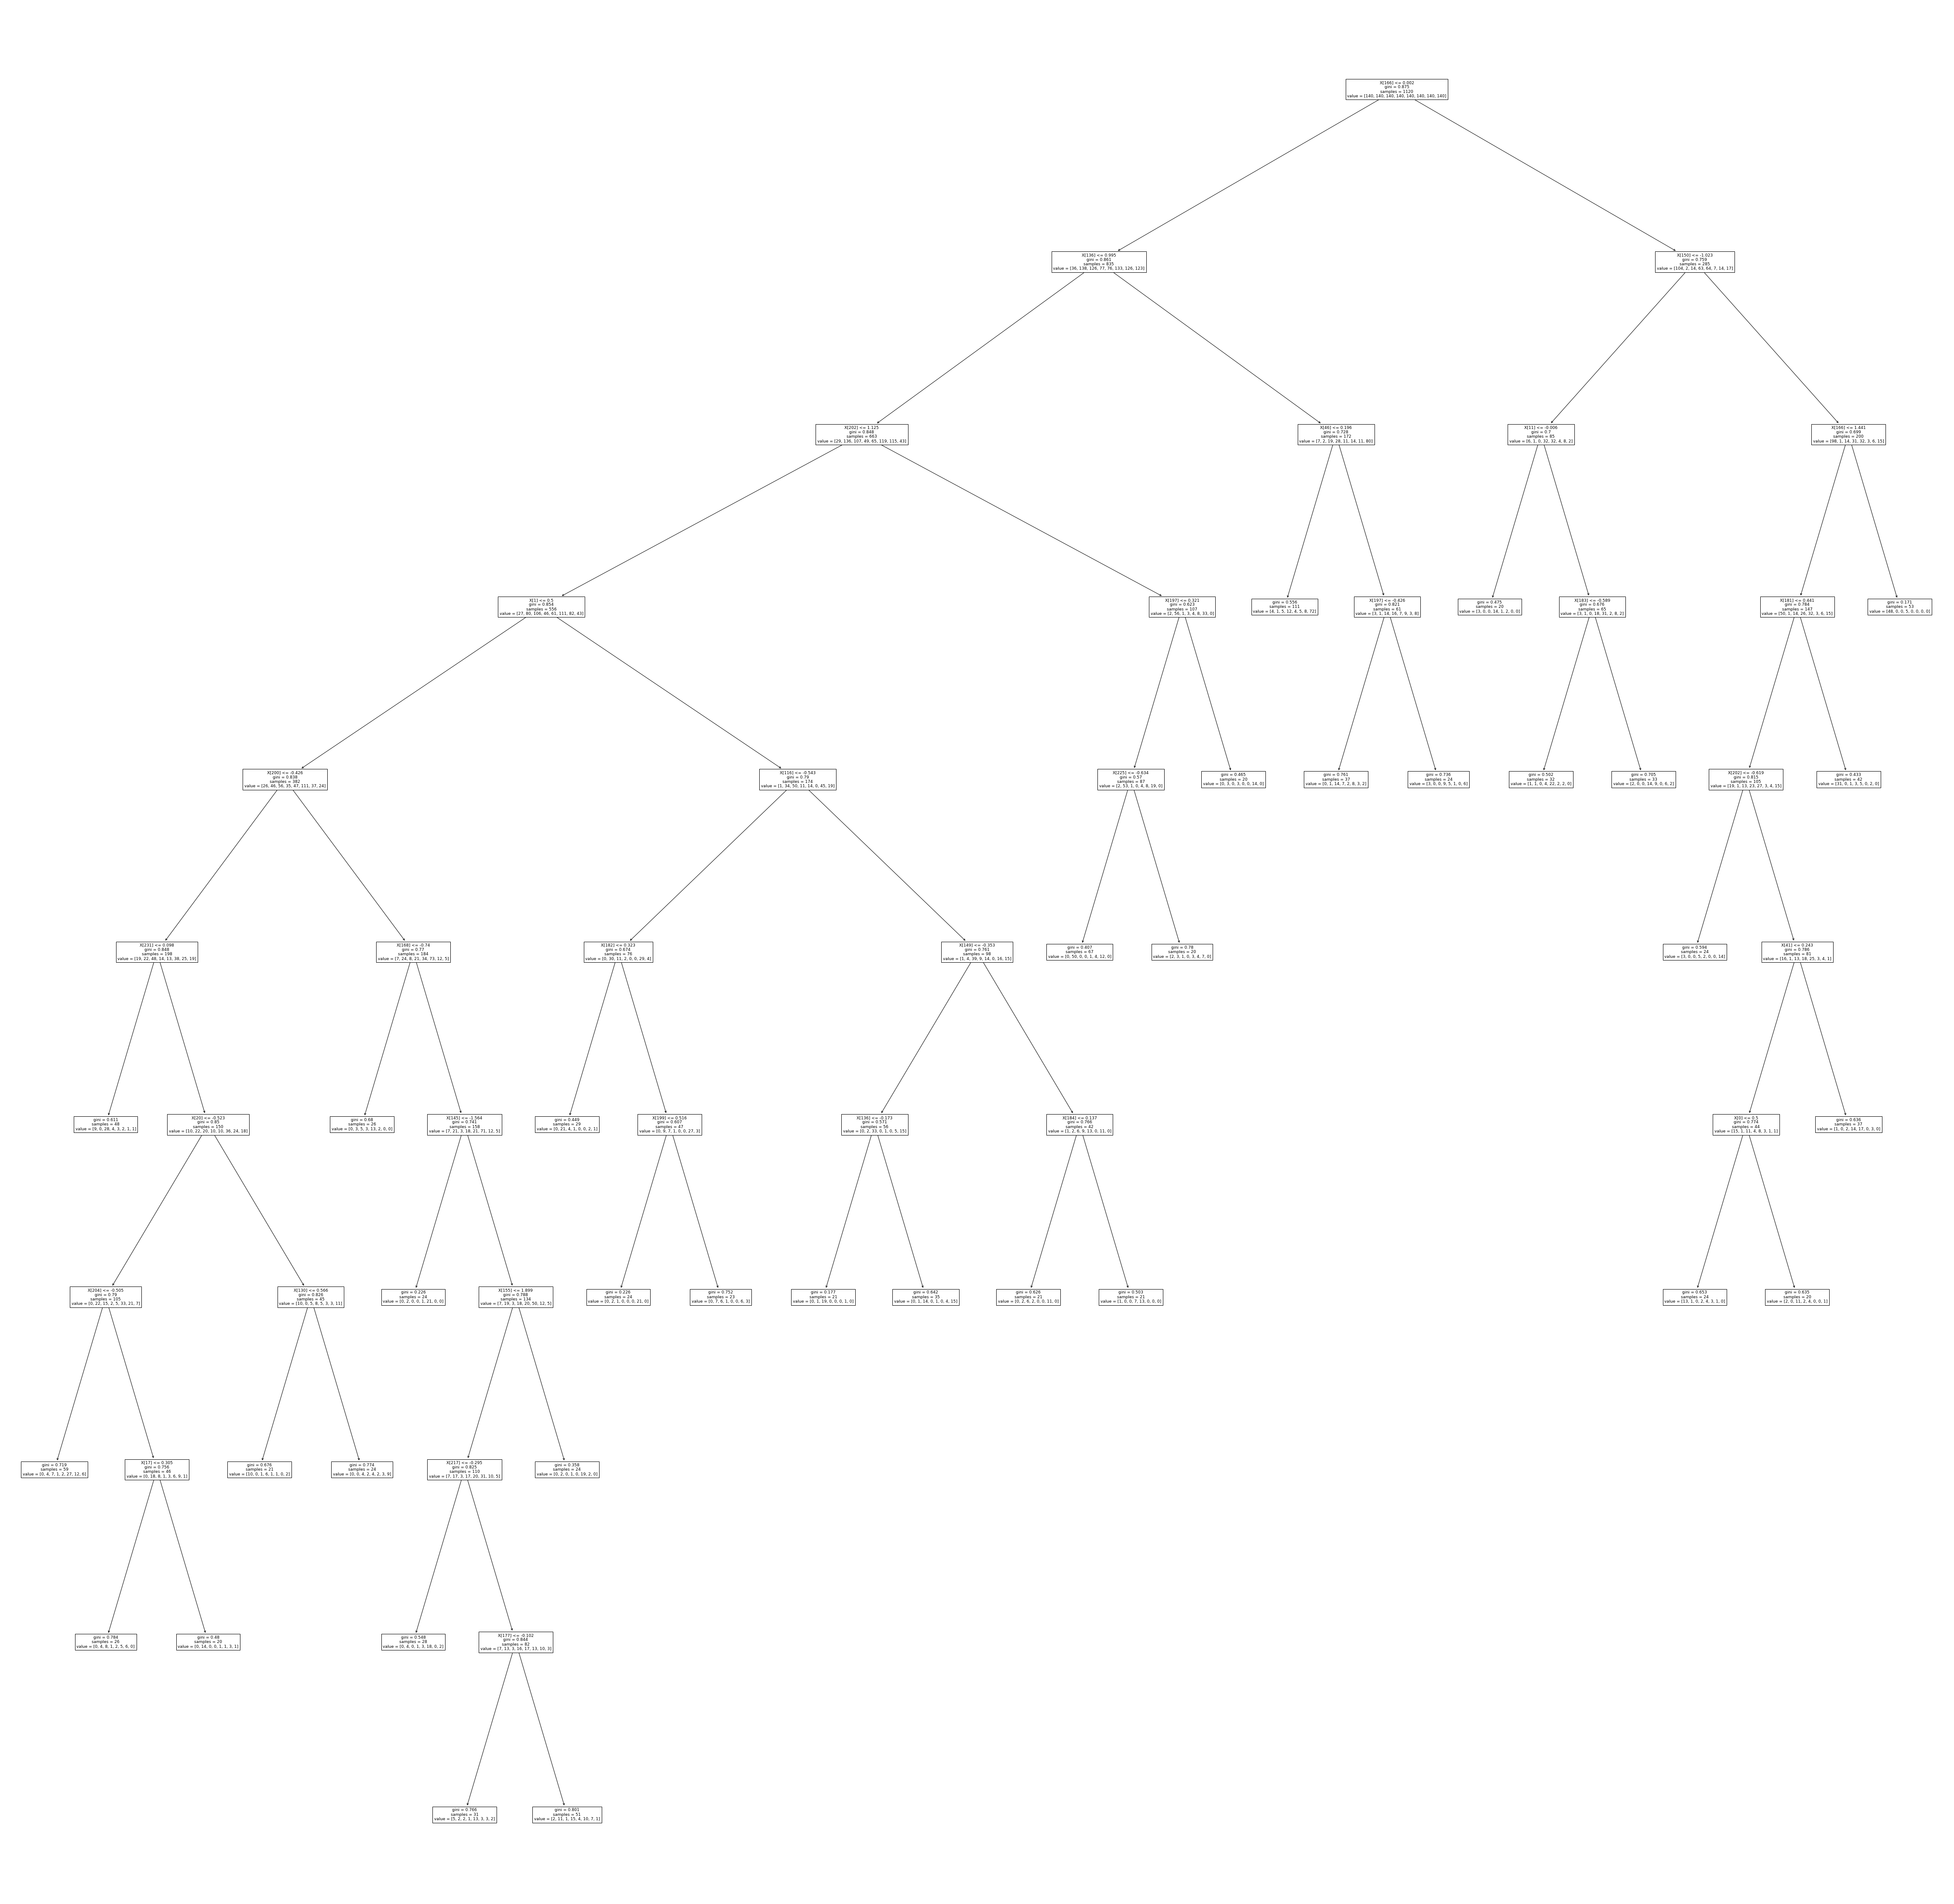

In [170]:
prune_duplicate_leaves(clf)

plt.figure(figsize=(80,80))
tree.plot_tree(clf)
plt.show()

# Dimensionality Reduction (Feature Selection)

In [173]:
from sklearn.feature_selection import VarianceThreshold

Variance Threshold

In [216]:
#Let's test different Threshold for DT and KNN
thresholds = [0.02, 0.04, 0.06, 0.08, 0.1, 0.12, 0.15, 0.16, 0.25, 1]
for i in thresholds:
    sel = VarianceThreshold(i)
    print(str(i))
    X_train_sel = sel.fit_transform(X_train)
    print(X_train_sel.shape)
    X_test_sel = sel.transform(X_test)

    learner= DecisionTreeClassifier(max_depth=10, min_samples_split=2, min_samples_leaf=20)
    learner.fit(X_train_sel, y_train)
    y_pred = learner.predict(X_test_sel)
    print('DT - Accuracy %s' % accuracy_score(y_test, y_pred))
    print('DT - F1 Score %s' % f1_score(y_test, y_pred,average="macro"))

    learner= KNeighborsClassifier(n_neighbors= 40, metric= 'cityblock', weights= 'distance')
    learner.fit(X_train_sel, y_train)
    y_pred = learner.predict(X_test_sel)
    print('KNN - Accuracy %s' % accuracy_score(y_test, y_pred))
    print('KNN - F1 Score %s' % f1_score(y_test, y_pred,average="macro"))

0.02
(1828, 258)
DT - Accuracy 0.34935897435897434
DT - F1 Score 0.3471075021443767
KNN - Accuracy 0.41185897435897434
KNN - F1 Score 0.393140358616175
0.04
(1828, 258)
DT - Accuracy 0.34935897435897434
DT - F1 Score 0.3471075021443767
KNN - Accuracy 0.41185897435897434
KNN - F1 Score 0.393140358616175
0.06
(1828, 258)
DT - Accuracy 0.34935897435897434
DT - F1 Score 0.3471075021443767
KNN - Accuracy 0.41185897435897434
KNN - F1 Score 0.393140358616175
0.08
(1828, 258)
DT - Accuracy 0.34935897435897434
DT - F1 Score 0.3471075021443767
KNN - Accuracy 0.41185897435897434
KNN - F1 Score 0.393140358616175
0.1
(1828, 258)
DT - Accuracy 0.34935897435897434
DT - F1 Score 0.3471075021443767
KNN - Accuracy 0.41185897435897434
KNN - F1 Score 0.393140358616175
0.12
(1828, 258)
DT - Accuracy 0.34935897435897434
DT - F1 Score 0.3471075021443767
KNN - Accuracy 0.41185897435897434
KNN - F1 Score 0.393140358616175
0.15
(1828, 258)
DT - Accuracy 0.34935897435897434
DT - F1 Score 0.3471075021443767
KNN -

In [ ]:
"""
Come si può vedere dai risultati del precedente esperimento, le uniche feature che vengono cancellate per la Varianza
sono quelle categoriche(da 0.25 di threshold in poi) mentre le altre numeriche hanno varianza altissima e non vengono mai cancellate.
"""

In [217]:
# Proviamo lo stesso esperimento però sui dati non normalizzati

df_train_pure=pd.read_csv("../Dataset_prepared/Prepared_train.csv")
df_test_pure=pd.read_csv("../Dataset_prepared/Prepared_test.csv")

df_train_pure.drop('actor',axis=1,inplace=True)
df_train_pure.drop('filename',axis=1,inplace=True)

df_test_pure.drop('actor',axis=1,inplace=True)
df_test_pure.drop('filename',axis=1,inplace=True)

le=preprocessing.LabelEncoder()
c = df_train_pure.select_dtypes(include=['object']).columns.tolist()
for i in c:
    df_train_pure[i]=le.fit_transform(df_train_pure[i])

for i in c:
    df_test_pure[i]=le.fit_transform(df_test_pure[i])

col=[x for x in df_train_pure.columns if x!="emotion"]
X_train_pure=df_train_pure[col].values
y_train_pure = np.array(df_train_pure["emotion"])

X_test_pure=df_test_pure[col].values
y_test_pure = np.array(df_test_pure["emotion"])


#Let's test different Threshold for DT and KNN
thresholds = [0.02, 0.04, 0.06, 0.08, 0.1, 0.12, 0.15, 0.16, 0.25,0.50,0.70]
for i in thresholds:
    sel = VarianceThreshold(i)
    print(str(i))
    X_train_sel = sel.fit_transform(X_train_pure)
    print(X_train_sel.shape)
    X_test_sel = sel.transform(X_test_pure)

    learner= DecisionTreeClassifier(max_depth=10, min_samples_split=2, min_samples_leaf=20)
    learner.fit(X_train_sel, y_train_pure)
    y_pred = learner.predict(X_test_sel)
    print('DT - Accuracy %s' % accuracy_score(y_test_pure, y_pred))
    print('DT - F1 Score %s' % f1_score(y_test_pure, y_pred,average="macro"))

    learner= KNeighborsClassifier(n_neighbors= 40, metric= 'cityblock', weights= 'distance')
    learner.fit(X_train_sel, y_train_pure)
    y_pred = learner.predict(X_test_sel)
    print('KNN - Accuracy %s' % accuracy_score(y_test_pure, y_pred))
    print('KNN - F1 Score %s' % f1_score(y_test_pure, y_pred,average="macro"))




0.02
(1828, 184)
DT - Accuracy 0.3782051282051282
DT - F1 Score 0.3710439551610446
KNN - Accuracy 0.2564102564102564
KNN - F1 Score 0.21733914102619914
0.04
(1828, 180)
DT - Accuracy 0.3766025641025641
DT - F1 Score 0.3679029286939856
KNN - Accuracy 0.2564102564102564
KNN - F1 Score 0.21733914102619914
0.06
(1828, 175)
DT - Accuracy 0.3766025641025641
DT - F1 Score 0.3679029286939856
KNN - Accuracy 0.2564102564102564
KNN - F1 Score 0.21733914102619914
0.08
(1828, 174)
DT - Accuracy 0.3766025641025641
DT - F1 Score 0.3679029286939856
KNN - Accuracy 0.2564102564102564
KNN - F1 Score 0.21733914102619914
0.1
(1828, 173)
DT - Accuracy 0.3766025641025641
DT - F1 Score 0.3679029286939856
KNN - Accuracy 0.2564102564102564
KNN - F1 Score 0.21733914102619914
0.12
(1828, 170)
DT - Accuracy 0.3766025641025641
DT - F1 Score 0.3679029286939856
KNN - Accuracy 0.2564102564102564
KNN - F1 Score 0.21733914102619914
0.15
(1828, 166)
DT - Accuracy 0.3766025641025641
DT - F1 Score 0.36750114297969994
KNN -

Univariate Feature Selection

In [202]:
from sklearn.feature_selection import SelectKBest

In [218]:
#Let's test different Threshold for DT and KNN
for i in range(20, 60):
    sel = SelectKBest(k=i)
    print(str(i))
    X_train_sel = sel.fit_transform(X_train, y_train)
    print(X_train_sel.shape)
    X_test_sel = sel.transform(X_test)

    learner= DecisionTreeClassifier(max_depth=10, min_samples_split=2, min_samples_leaf=20)
    learner.fit(X_train_sel, y_train)
    y_pred = learner.predict(X_test_sel)
    print('DT - Accuracy %s' % accuracy_score(y_test, y_pred))
    print('DT - F1 Score %s' % f1_score(y_test, y_pred,average="macro"))

    learner= KNeighborsClassifier(n_neighbors= 40, metric= 'cityblock', weights= 'distance')
    learner.fit(X_train_sel, y_train)
    y_pred = learner.predict(X_test_sel)
    print('KNN - Accuracy %s' % accuracy_score(y_test, y_pred))
    print('KNN - F1 Score %s' % f1_score(y_test, y_pred,average="macro"))


20
(1828, 20)
DT - Accuracy 0.3605769230769231
DT - F1 Score 0.34643243608301316
KNN - Accuracy 0.38301282051282054
KNN - F1 Score 0.3588253148367766
21
(1828, 21)
DT - Accuracy 0.34775641025641024
DT - F1 Score 0.32921537999703593
KNN - Accuracy 0.3814102564102564
KNN - F1 Score 0.3496241654368496
22
(1828, 22)
DT - Accuracy 0.34455128205128205
DT - F1 Score 0.31237155194942473
KNN - Accuracy 0.3782051282051282
KNN - F1 Score 0.35978125953365503
23
(1828, 23)
DT - Accuracy 0.34134615384615385
DT - F1 Score 0.3137860054843863
KNN - Accuracy 0.38301282051282054
KNN - F1 Score 0.3595077494800736
24
(1828, 24)
DT - Accuracy 0.34615384615384615
DT - F1 Score 0.3285374797097984
KNN - Accuracy 0.38301282051282054
KNN - F1 Score 0.3612731253887481
25
(1828, 25)
DT - Accuracy 0.34615384615384615
DT - F1 Score 0.3257777131298354
KNN - Accuracy 0.391025641025641
KNN - F1 Score 0.37678984119869985
26
(1828, 26)
DT - Accuracy 0.3525641025641026
DT - F1 Score 0.32977504387124523
KNN - Accuracy 0.39

Select from model

In [9]:
from sklearn.feature_selection import SelectFromModel

In [10]:
sel = SelectFromModel(DecisionTreeClassifier(max_depth=10, min_samples_split=2, min_samples_leaf=20))
X_train_sel = sel.fit_transform(X_train, y_train)
print(f"DT New dimension:{X_train_sel.shape}\n")

X_test_sel = sel.transform(X_test)
clf = DecisionTreeClassifier(max_depth=10, min_samples_split=2, min_samples_leaf=20)
clf.fit(X_train_sel, y_train)
y_pred = clf.predict(X_test_sel)
print(classification_report(y_test, y_pred))

DT New dimension:(1828, 49)

              precision    recall  f1-score   support

           0       0.46      0.61      0.53        96
           1       0.47      0.33      0.39        96
           2       0.31      0.29      0.30        48
           3       0.26      0.21      0.23        96
           4       0.24      0.22      0.23        96
           5       0.29      0.48      0.36        48
           6       0.31      0.29      0.30        96
           7       0.44      0.44      0.44        48

    accuracy                           0.35       624
   macro avg       0.35      0.36      0.35       624
weighted avg       0.35      0.35      0.34       624



In [229]:
sel = SelectFromModel(DecisionTreeClassifier(max_depth=10, min_samples_split=2, min_samples_leaf=20))
X_train_sel = sel.fit_transform(X_train, y_train)
print(f"New dimension:{X_train_sel.shape}\n")

X_test_sel = sel.transform(X_test)
clf = KNeighborsClassifier(n_neighbors= 40, metric= 'cityblock', weights= 'distance')
clf.fit(X_train_sel, y_train)
y_pred = clf.predict(X_test_sel)
print(classification_report(y_test, y_pred))

# Ho fatto selezione sul modello del decision tree e testato il knn nella nuova dimensione

New dimension:(1828, 49)

              precision    recall  f1-score   support

           0       0.60      0.66      0.63        96
           1       0.48      0.65      0.55        96
           2       0.42      0.35      0.39        48
           3       0.45      0.39      0.41        96
           4       0.39      0.45      0.42        96
           5       0.42      0.42      0.42        48
           6       0.29      0.18      0.22        96
           7       0.41      0.44      0.42        48

    accuracy                           0.45       624
   macro avg       0.43      0.44      0.43       624
weighted avg       0.44      0.45      0.44       624



Recursive Feature Elimination

In [231]:
from sklearn.feature_selection import RFE

In [233]:
#Let's test different k range for DT and KNN
for i in range(20, 60):
    print(str(i))

    sel = RFE(DecisionTreeClassifier(max_depth=10, min_samples_split=2, min_samples_leaf=20), n_features_to_select=i)
    X_train_sel = sel.fit_transform(X_train, y_train)
    print(f" DT New dimension: {X_train_sel.shape}")
    X_test_sel = sel.transform(X_test)

    learner= DecisionTreeClassifier(max_depth=10, min_samples_split=2, min_samples_leaf=20)
    learner.fit(X_train_sel, y_train)
    y_pred = learner.predict(X_test_sel)
    print('DT - Accuracy %s' % accuracy_score(y_test, y_pred))
    print('DT - F1 Score %s' % f1_score(y_test, y_pred,average="macro"))

    learner= KNeighborsClassifier(n_neighbors= 40, metric= 'cityblock', weights= 'distance')
    learner.fit(X_train_sel, y_train)
    y_pred = learner.predict(X_test_sel)
    print('KNN - Accuracy %s' % accuracy_score(y_test, y_pred))
    print('KNN - F1 Score %s' % f1_score(y_test, y_pred,average="macro"))

20
 DT New dimension: (1828, 20)
DT - Accuracy 0.3766025641025641
DT - F1 Score 0.3650405033266815
KNN - Accuracy 0.46634615384615385
KNN - F1 Score 0.45838176306540546
21
 DT New dimension: (1828, 21)
DT - Accuracy 0.375
DT - F1 Score 0.37177788138491696
KNN - Accuracy 0.4599358974358974
KNN - F1 Score 0.45291635064060287
22
 DT New dimension: (1828, 22)
DT - Accuracy 0.36378205128205127
DT - F1 Score 0.36086613703335296
KNN - Accuracy 0.46955128205128205
KNN - F1 Score 0.46360743973380925
23
 DT New dimension: (1828, 23)
DT - Accuracy 0.3541666666666667
DT - F1 Score 0.35125971860491234
KNN - Accuracy 0.4599358974358974
KNN - F1 Score 0.45202439230613584
24
 DT New dimension: (1828, 24)
DT - Accuracy 0.34294871794871795
DT - F1 Score 0.34169696607278915
KNN - Accuracy 0.46794871794871795
KNN - F1 Score 0.45922699966672126
25
 DT New dimension: (1828, 25)
DT - Accuracy 0.34615384615384615
DT - F1 Score 0.3439736059861278
KNN - Accuracy 0.4326923076923077
KNN - F1 Score 0.4307999147709

# Dimensionality Reduction (Feature Projection)

PCA

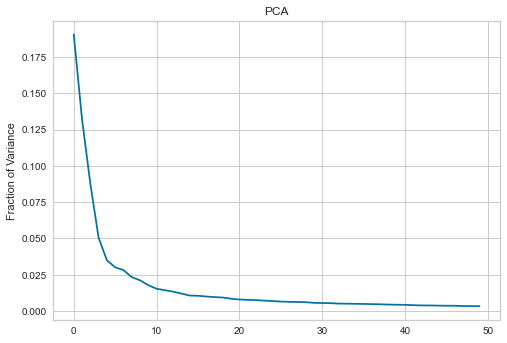

In [255]:
plt.plot(PCA(n_components=50).fit(X_train,y_train).explained_variance_ratio_)
plt.title("PCA")
plt.ylabel("Fraction of Variance")
plt.show()

In [273]:
pca = PCA(n_components=30)
pca.fit(X_train)
X_train_pca = pca.transform(X_train)

In [274]:
X_test_pca = pca.transform(X_test)
clf = DecisionTreeClassifier(max_depth=10, min_samples_split=2, min_samples_leaf=20)
clf.fit(X_train_pca, y_train)
y_pred = clf.predict(X_test_pca)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.59      0.54      0.57        96
           1       0.34      0.33      0.34        96
           2       0.31      0.19      0.23        48
           3       0.25      0.30      0.28        96
           4       0.24      0.31      0.27        96
           5       0.42      0.17      0.24        48
           6       0.28      0.29      0.29        96
           7       0.22      0.25      0.23        48

    accuracy                           0.32       624
   macro avg       0.33      0.30      0.31       624
weighted avg       0.34      0.32      0.32       624



In [275]:
X_test_pca = pca.transform(X_test)
clf = KNeighborsClassifier(n_neighbors= 40, metric= 'cityblock', weights= 'distance')
clf.fit(X_train_pca, y_train)
y_pred = clf.predict(X_test_pca)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.53      0.67      0.59        96
           1       0.42      0.53      0.47        96
           2       0.43      0.42      0.43        48
           3       0.43      0.38      0.40        96
           4       0.35      0.40      0.37        96
           5       0.36      0.21      0.26        48
           6       0.39      0.25      0.31        96
           7       0.32      0.38      0.35        48

    accuracy                           0.42       624
   macro avg       0.41      0.40      0.40       624
weighted avg       0.41      0.42      0.41       624



Random Subspace Projection

In [11]:
from sklearn import random_projection

rsp = random_projection.GaussianRandomProjection(n_components=30, random_state=0)
X_train_rsp = rsp.fit_transform(X_train)
X_train_rsp.shape

(1828, 30)

In [12]:
X_test_rsp = rsp.transform(X_test)
clf = DecisionTreeClassifier(max_depth=10, min_samples_split=2, min_samples_leaf=20)
clf.fit(X_train_rsp, y_train)
y_pred = clf.predict(X_test_rsp)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.32      0.39      0.35        96
           1       0.20      0.27      0.23        96
           2       0.25      0.06      0.10        48
           3       0.24      0.29      0.26        96
           4       0.26      0.25      0.25        96
           5       0.21      0.19      0.20        48
           6       0.27      0.22      0.24        96
           7       0.26      0.19      0.22        48

    accuracy                           0.25       624
   macro avg       0.25      0.23      0.23       624
weighted avg       0.25      0.25      0.25       624



In [13]:
clf = KNeighborsClassifier(n_neighbors= 40, metric= 'cityblock', weights= 'distance')
clf.fit(X_train_rsp, y_train)
y_pred = clf.predict(X_test_rsp)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.43      0.50      0.46        96
           1       0.33      0.46      0.38        96
           2       0.37      0.21      0.27        48
           3       0.39      0.28      0.33        96
           4       0.31      0.27      0.29        96
           5       0.29      0.08      0.13        48
           6       0.25      0.23      0.24        96
           7       0.24      0.48      0.32        48

    accuracy                           0.33       624
   macro avg       0.33      0.31      0.30       624
weighted avg       0.33      0.33      0.32       624



Multi Dimensional Scaling

In [14]:
from sklearn.manifold import MDS

In [15]:
mds = MDS(n_components=2) #, normalized_stress='auto') # shoudl run as sammon mapping
X_train_mds = mds.fit_transform(X_train)
X_train_mds.shape

(1828, 2)

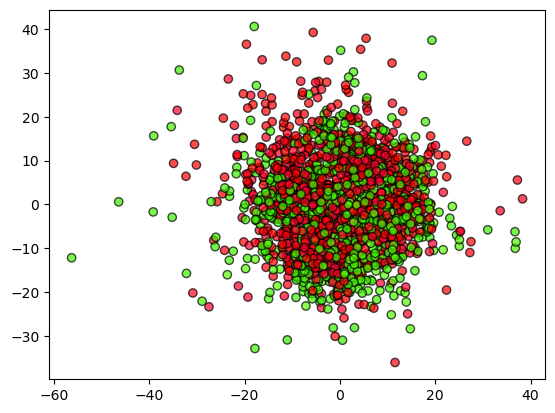

In [16]:
plt.scatter(X_train_mds[:, 0], X_train_mds[:, 1], c=y_train, cmap=plt.cm.prism, edgecolor='k', alpha=0.7)
plt.show()

In [323]:
#X_test_mds = mds.fit_transform(X_test) # no transform
clf = DecisionTreeClassifier(max_depth=10, min_samples_split=2, min_samples_leaf=20)
clf.fit(X_train_mds, y_train)

y_pred = clf.predict(X_train_mds)

print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.62      0.59      0.61       280
           1       0.49      0.62      0.55       280
           2       0.33      0.45      0.38       144
           3       0.43      0.42      0.43       280
           4       0.44      0.44      0.44       280
           5       0.44      0.21      0.28       140
           6       0.44      0.47      0.45       280
           7       0.56      0.35      0.43       144

    accuracy                           0.47      1828
   macro avg       0.47      0.44      0.45      1828
weighted avg       0.47      0.47      0.46      1828



In [324]:
#X_test_mds = mds.fit_transform(X_test) # no transform
clf = KNeighborsClassifier(n_neighbors= 40, metric= 'cityblock', weights= 'distance')
clf.fit(X_train_mds, y_train)

y_pred = clf.predict(X_train_mds)

print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       280
           1       1.00      1.00      1.00       280
           2       1.00      1.00      1.00       144
           3       1.00      1.00      1.00       280
           4       1.00      1.00      1.00       280
           5       1.00      1.00      1.00       140
           6       1.00      1.00      1.00       280
           7       1.00      1.00      1.00       144

    accuracy                           1.00      1828
   macro avg       1.00      1.00      1.00      1828
weighted avg       1.00      1.00      1.00      1828



IsoMap

In [17]:
from sklearn.manifold import Isomap

In [18]:
iso = Isomap(n_components=2)
X_train_iso = iso.fit_transform(X_train)
X_train_iso.shape

(1828, 2)

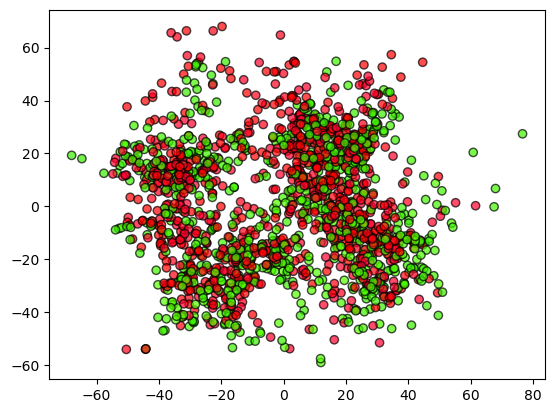

In [19]:
plt.scatter(X_train_iso[:, 0], X_train_iso[:, 1], c=y_train, cmap=plt.cm.prism, edgecolor='k', alpha=0.7)
plt.show()

In [20]:
#X_test_iso = iso.fit_transform(X_test) # no transform
clf = DecisionTreeClassifier(max_depth=10, min_samples_split=2, min_samples_leaf=20)
clf.fit(X_train_mds, y_train)

y_pred = clf.predict(X_train_iso)

print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.19      0.48      0.27       280
           1       0.16      0.46      0.24       280
           2       0.13      0.02      0.04       144
           3       0.22      0.10      0.14       280
           4       0.15      0.02      0.04       280
           5       0.00      0.00      0.00       140
           6       0.16      0.05      0.07       280
           7       0.16      0.05      0.07       144

    accuracy                           0.18      1828
   macro avg       0.15      0.15      0.11      1828
weighted avg       0.16      0.18      0.13      1828



In [21]:
#X_test_iso = iso.fit_transform(X_test) # no transform
clf = KNeighborsClassifier(n_neighbors= 40, metric= 'cityblock', weights= 'distance')
clf.fit(X_train_mds, y_train)

y_pred = clf.predict(X_train_iso)

print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.19      0.46      0.27       280
           1       0.17      0.17      0.17       280
           2       0.15      0.08      0.11       144
           3       0.14      0.18      0.16       280
           4       0.18      0.04      0.07       280
           5       0.11      0.06      0.08       140
           6       0.12      0.04      0.06       280
           7       0.11      0.16      0.13       144

    accuracy                           0.16      1828
   macro avg       0.15      0.15      0.13      1828
weighted avg       0.15      0.16      0.14      1828



t-SNE

In [22]:
from sklearn.manifold import TSNE

In [24]:
tsne = TSNE(n_components=2)
X_train_tsne = tsne.fit_transform(X_train)
X_train_tsne.shape

c:\Users\david\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\david\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


(1828, 2)

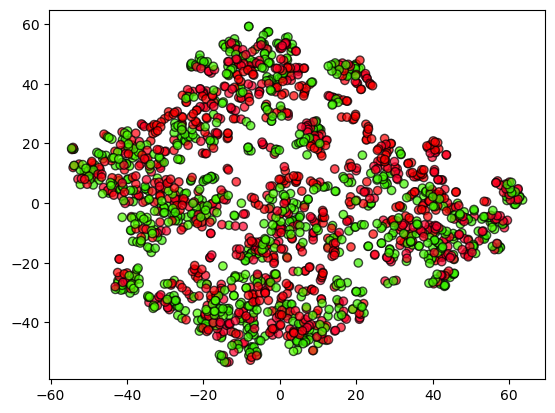

In [25]:
plt.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1], c=y_train, cmap=plt.cm.prism, edgecolor='k', alpha=0.7)
plt.show()

In [26]:
#X_test_tsne = tsne.fit_transform(X_test) # no transform

clf = DecisionTreeClassifier(max_depth=10, min_samples_split=2, min_samples_leaf=20)
clf.fit(X_train_tsne, y_train)

y_pred = clf.predict(X_train_tsne)

print('Accuracy %s' % accuracy_score(y_train, y_pred))
print('F1-score %s' % f1_score(y_train, y_pred, average=None))
print(classification_report(y_train, y_pred))

Accuracy 0.43052516411378555
F1-score [0.54853621 0.51623377 0.34250765 0.46153846 0.39393939 0.18957346
 0.39382239 0.33846154]
              precision    recall  f1-score   support

           0       0.48      0.64      0.55       280
           1       0.47      0.57      0.52       280
           2       0.31      0.39      0.34       144
           3       0.55      0.40      0.46       280
           4       0.37      0.42      0.39       280
           5       0.28      0.14      0.19       140
           6       0.43      0.36      0.39       280
           7       0.38      0.31      0.34       144

    accuracy                           0.43      1828
   macro avg       0.41      0.40      0.40      1828
weighted avg       0.43      0.43      0.42      1828



In [27]:
#X_test_tsne = tsne.fit_transform(X_test) # no transform

clf = KNeighborsClassifier(n_neighbors= 40, metric= 'cityblock', weights= 'distance')
clf.fit(X_train_tsne, y_train)

y_pred = clf.predict(X_train_tsne)

print('Accuracy %s' % accuracy_score(y_train, y_pred))
print('F1-score %s' % f1_score(y_train, y_pred, average=None))
print(classification_report(y_train, y_pred))

Accuracy 1.0
F1-score [1. 1. 1. 1. 1. 1. 1. 1.]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       280
           1       1.00      1.00      1.00       280
           2       1.00      1.00      1.00       144
           3       1.00      1.00      1.00       280
           4       1.00      1.00      1.00       280
           5       1.00      1.00      1.00       140
           6       1.00      1.00      1.00       280
           7       1.00      1.00      1.00       144

    accuracy                           1.00      1828
   macro avg       1.00      1.00      1.00      1828
weighted avg       1.00      1.00      1.00      1828



In [337]:
"""
Come si può evincere dagli esperimenti MDS,IsoMap, t-SNE ho lasciato il testing del modello sempre sul train come i notebook
del professore ma questa cosa nopn mi torna per niente, infatti dobbiamo chiderglielo.
TODO: Ultima cosa che rimane da fare è crearsi un modello con la migliore combinazione di Sampling + Dim. Reduction

"""

'\nCome si può evincere dagli esperimenti MDS,IsoMap, t-SNE ho lasciato il testing del modello sempre sul train come i notebook\ndel professore ma questa cosa nopn mi torna per niente, infatti dobbiamo chiderglielo.\nTODO: Ultima cosa che rimane da fare è crearsi un modello con la migliore combinazione di Sampling + Dim. Reduction\n\n'

# Now we build two models with  the best sampling technics + best reduction technics based on the previous experiments

DT (Random Undersampler + Univariate Feature Selection(SelectKBest) with k=58 )

In [30]:
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({0: 140, 1: 140, 2: 140, 3: 140, 4: 140, 5: 140, 6: 140, 7: 140})


In [34]:
learner= DecisionTreeClassifier(max_depth=10, min_samples_split=2, min_samples_leaf=20)
learner.fit(X_res, y_res)
y_pred = learner.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.56      0.57      0.57        96
           1       0.56      0.57      0.56        96
           2       0.18      0.29      0.22        48
           3       0.30      0.20      0.24        96
           4       0.38      0.32      0.35        96
           5       0.39      0.44      0.41        48
           6       0.49      0.23      0.31        96
           7       0.32      0.71      0.44        48

    accuracy                           0.40       624
   macro avg       0.40      0.42      0.39       624
weighted avg       0.42      0.40      0.40       624



In [38]:
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({0: 140, 1: 140, 2: 140, 3: 140, 4: 140, 5: 140, 6: 140, 7: 140})


In [39]:
from sklearn.feature_selection import SelectKBest

sel = SelectKBest(k=58)
X_train_sel = sel.fit_transform(X_res, y_res)
print(X_train_sel.shape)
X_test_sel = sel.transform(X_test)

learner= DecisionTreeClassifier(max_depth=10, min_samples_split=2, min_samples_leaf=20)
learner.fit(X_train_sel, y_res)
y_pred = learner.predict(X_test_sel)
print(classification_report(y_test, y_pred))


(1120, 58)
              precision    recall  f1-score   support

           0       0.59      0.59      0.59        96
           1       0.40      0.34      0.37        96
           2       0.24      0.56      0.34        48
           3       0.27      0.23      0.25        96
           4       0.38      0.22      0.28        96
           5       0.31      0.50      0.38        48
           6       0.25      0.08      0.12        96
           7       0.42      0.75      0.54        48

    accuracy                           0.37       624
   macro avg       0.36      0.41      0.36       624
weighted avg       0.36      0.37      0.34       624



In [40]:
"""
Da questo esperimento si può notare come il modello basato sul DT performi meglio con la sola tecnica di Sampling
rispetto alla combinazione sampling + dim.reduction

"""

'\nDa questo esperimento si può notare come il modello basato sul DT performi meglio con la sola tecnica di Sampling\nrispetto alla combinazione sampling + dim.reduction\n\n'

KK(Tomek Links + )

In [41]:
from imblearn.under_sampling import TomekLinks

tl = TomekLinks()
X_res, y_res = tl.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({0: 261, 3: 255, 1: 251, 6: 250, 4: 249, 5: 140, 2: 128, 7: 128})


In [44]:
learner = KNeighborsClassifier(n_neighbors= 40, metric= 'cityblock', weights= 'distance')
learner.fit(X_res, y_res)
y_pred = learner.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.52      0.60      0.56        96
           1       0.41      0.53      0.46        96
           2       0.48      0.27      0.35        48
           3       0.48      0.34      0.40        96
           4       0.35      0.39      0.36        96
           5       0.39      0.38      0.38        48
           6       0.32      0.25      0.28        96
           7       0.34      0.46      0.39        48

    accuracy                           0.41       624
   macro avg       0.41      0.40      0.40       624
weighted avg       0.41      0.41      0.40       624



In [48]:
from imblearn.under_sampling import TomekLinks

tl = TomekLinks()
X_res, y_res = tl.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({0: 261, 3: 255, 1: 251, 6: 250, 4: 249, 5: 140, 2: 128, 7: 128})


In [49]:
from sklearn.feature_selection import RFE

sel = RFE(DecisionTreeClassifier(max_depth=10, min_samples_split=2, min_samples_leaf=20), n_features_to_select=22)
X_train_sel = sel.fit_transform(X_res, y_res)
print(f" DT New dimension: {X_train_sel.shape}")
X_test_sel = sel.transform(X_test)

learner = KNeighborsClassifier(n_neighbors= 40, metric= 'cityblock', weights= 'distance')
learner.fit(X_train_sel, y_res)
y_pred = learner.predict(X_test_sel)
print(classification_report(y_test,y_pred))

 DT New dimension: (1662, 22)
              precision    recall  f1-score   support

           0       0.61      0.67      0.64        96
           1       0.56      0.56      0.56        96
           2       0.50      0.44      0.47        48
           3       0.58      0.32      0.42        96
           4       0.47      0.49      0.48        96
           5       0.35      0.73      0.47        48
           6       0.41      0.28      0.33        96
           7       0.48      0.62      0.55        48

    accuracy                           0.50       624
   macro avg       0.50      0.51      0.49       624
weighted avg       0.51      0.50      0.49       624



In [50]:
"""
Da questo esperimento si può notare come combinando le miglliori tecniche di Sampling + Dim. Reduction
siamo riusciti ad ottenre un modello che raggiunga il 50% di accuracy sui dati di test,
contrariamente agli altri vari modelli che non rusperavano il 46%

Resta da chiedere al professore se è giusto utilizzare la RFE su un DT per restituirmi il migliore spazio e poi
allenare un modello di KNN  sullo spazio creato dalle statistiche sul DT

"""

'\nDa questo esperimento si può notare come combinando le miglliori tecniche di Sampling + Dim. Reduction\nsiamo riusciti ad ottenre un modello che raggiunga il 50% di accuracy sui dati di test,\ncontrariamente agli altri vari modelli che non rusperavano il 46%\n\nResta da chiedere al professore se è giusto utilizzare la RFE su un DT per restituirmi il migliore spazio e poi\nallenare un modello di KNN  sullo spazio creato dalle statistiche sul DT\n\n'